In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Libraries

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug

from keras.applications import vgg16, vgg19
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Variables

In [0]:
# root path of the project
ROOT_PATH = 'drive/My Drive/medical_image_recognition/'
save_path = 'drive/My Drive/medical_image_recognition/notebooks_Chen/'
#ROOT_PATH = '/home/hippolyte/Documents/universite/m1/TER/'

# name of the dataset
DATASET_NAME = 'chest_xray'

# define image extensions we accept
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']

# dimensions for the images
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

# output var to see infos
VERBOSE = True

# paths to each directory
directory_list = None #['test', 'train', 'val']

# labels for each directory
# if setup to None, detect according to subdirectories inside each directory
label_list = None #['NORMAL', 'PNEUMONIA']

# image augmentation sequence
# WE DON'T USE THAT YET
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # rotation

# the next instructions are used to make results reproducible
seed = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
tf.set_random_seed(seed)
aug.seed(seed)

################################################################################
# DON'T TOUCH THE VARIABLES UNDER
################################################################################

# these are helpers to ease consistency
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
MODEL_PATH = save_path + DATASET_NAME + '/'
ARRAY_PATH = ROOT_PATH + 'arrays/' + DATASET_NAME + '/'

# create the directories to save arrays and models if they don't exist
os.system('mkdir -p {} {}'.format(MODEL_PATH, ARRAY_PATH))

# list directories according to the list defined on top
if directory_list is None:
    DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
else:
    DIRECTORIES = directory_list

# get the labels inside the first directory
# of course, it should be the same in every directory
if label_list is None:
    LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))
else:
    LABELS = label_list

NUM_LABELS = len(LABELS)

# get the paths
PATHS = dict()
for cur_dir in DIRECTORIES:
    PATHS[cur_dir] = DATASET_PATH + cur_dir + '/'

# Data function

In [0]:
def get_data(directory: str):
    """
    TODO
    """
    with h5py.File(ARRAY_PATH + directory + '.h5', 'r') as file:
        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)

        print('Reading {} images from {} ...'.format(num_images, directory))

        # define arrays holding data and labels
        data = np.zeros((num_images, HEIGHT, WIDTH, CHANNELS), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Initial shapes. {}   {}'.format(data.shape,labels.shape))
    data = np.array(data).astype(np.float32)
    labels = np.array(labels)
    print('Final shapes. {}   {}'.format(data.shape, labels.shape))
    return data, labels

# Convolutional Neural Network functions

In [0]:
def get_cnn_model(model_name: str):
    """
    TODO
    """
    if model_name == 'vgg16':
        return create_vgg16()
    elif model_name == 'vgg16custom':
        return create_vgg16custom()
    elif model_name == 'vgg19':
        return create_vgg19()
    elif model_name == 'vgg19custom':
        return create_vgg19custom()
    else:
        raise ValueError(
                'The model {} isn\'t implemented yet'.format(model_name))

################################################################################
def create_vgg16():
    """
    TODO
    """
    base_model = vgg16.VGG16(include_top=False,
                             weights='imagenet',
                             input_shape=(HEIGHT, WIDTH, CHANNELS))

    model = Sequential()
    model.add(base_model)

    # add classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dropout(0.7, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))

    # see the base model architecture
    #base_model.summary()

    return model

################################################################################
def create_vgg16custom():
    """
    TODO
    """
    img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name='ImageInput')

    # block 1
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    #TODO
    # variables to change for SeparableConv2D
    # no activation in xception
    # use_bias=False

    # block 2
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv1')(x)
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # block 3
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv1')(x)
    x = BatchNormalization(name='block3_conv1_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv2')(x)
    x = BatchNormalization(name='block3_conv2_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # block 4
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv1')(x)
    x = BatchNormalization(name='block4_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv2')(x)
    x = BatchNormalization(name='block4_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # block 5
    # TODO

    # classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x) #4096
    x = Dropout(0.7, name='dropout1')(x) # not present
    x = Dense(512, activation='relu', name='fc2')(x) # 4096
    x = Dropout(0.5, name='dropout2')(x) # not present
    x = Dense(NUM_LABELS, activation='softmax', name='predictions')(x)

    # create the cnn
    model = Model(img_input, x, name='vgg16_custom')

    # !!! WEIGHTS !!!
    weights_path = MODEL_PATH + 'weights_notop.h5'
    print('Trying to load weights from {} ...'.format(weights_path))
    
    ### TODO cleaner
    from pathlib import Path
    weights_path = Path(weights_path)
    if not weights_path.is_file():
        vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
        vgg16_model.save_weights(weights_path)

    # load weights
    model.load_weights(weights_path, by_name=True)
    print('DONE')
    return model

################################################################################
def create_vgg19():
    """
    TODO
    """
    base_model = vgg19.VGG19(include_top=False,
                             weights='imagenet',
                             input_shape=(HEIGHT, WIDTH, CHANNELS))

    model = Sequential()
    model.add(base_model)

    # add classification block
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dropout(0.7, name='dropout1'))
    model.add(Dense(512, activation='relu', name='fc2'))
    model.add(Dropout(0.5, name='dropout2'))
    model.add(Dense(NUM_LABELS, activation='softmax', name='predictions'))

    #base_model.summary()
    #model.summary()

    return model

################################################################################
def create_vgg19custom():
    """
    TODO
    """
    img_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name='ImageInput')

    # block 1
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3),
               activation='relu',
               padding='same',
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    #TODO
    # variables to change for SeparableConv2D
    # no activation in xception
    # use_bias=False

    # block 2
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv1')(x)
    x = SeparableConv2D(128, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # block 3
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv1')(x)
    x = BatchNormalization(name='block3_conv1_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        #use_bias=False,
                        name='block3_conv2')(x)
    x = BatchNormalization(name='block3_conv2_bn')(x)
    x = SeparableConv2D(256, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # block 4
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv1')(x)
    x = BatchNormalization(name='block4_conv1_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv2')(x)
    x = BatchNormalization(name='block4_conv2_bn')(x)
    x = SeparableConv2D(512, (3, 3),
                        activation='relu',
                        padding='same',
                        name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # block 5
    # TODO

    # classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x) #4096
    x = Dropout(0.7, name='dropout1')(x) # not present
    x = Dense(512, activation='relu', name='fc2')(x) # 4096
    x = Dropout(0.5, name='dropout2')(x) # not present
    x = Dense(NUM_LABELS, activation='softmax', name='predictions')(x)

    #TODO load weights here

    model = Model(img_input, x, name='vgg19custom')
    return model

def compile_model(model, model_name, learning_rate=1e-5):
    """
    TODO
    """
    optimizer = Adam(lr=learning_rate, decay=1e-5)
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=optimizer)

    return model

def train_model(model,
                model_name,
                train_data,
                train_labels,
                val_data,
                val_labels,
                epoch=20,
                batch_size=16,
                metric='val_loss',
                save_best_only=True,
                stop_after=5):
    """
    TODO
    """
    early_stopping = EarlyStopping(patience=stop_after, monitor=metric)

    check_path = MODEL_PATH + model_name + 'epoch{epoch:02d}_{val_acc:2f}.hdf5'
    checkpoint = ModelCheckpoint(check_path,
                                 save_best_only=save_best_only,
                                 save_weights_only=True,
                                 verbose=1)

    # steps per epoch
    train_steps = len(train_data) // batch_size
    val_steps = len(val_data)

    print('Training {} model during {} epochs'.format(model_name, epoch))
    print('{} train and {} val steps per epoch.'.format(train_steps, val_steps))

    # here we are, we'll train the model
    history = model.fit(x=train_data,
                        y=train_labels,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1,
                        callbacks=[early_stopping, checkpoint],
                        validation_split=0.0,
                        validation_data=(val_data, val_labels),
                        shuffle=True,
                        class_weight={0: 1.0, 1: 0.4}) # TODO

    return model, history

def test_model(model, model_name, test_data, test_labels, batch_size=16):
    """
    TODO
    """
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)

    print('Results for {} model.'.format(model_name))

    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))

    # predictions
    preds = model.predict(test_data, batch_size=16)
    preds = np.argmax(preds, axis=-1)

    # original labels
    orig_test_labels = np.argmax(test_labels, axis=-1)

    # shapes
    print(orig_test_labels.shape)
    print(preds.shape)

    ### confusion matrix
    cm  = confusion_matrix(orig_test_labels, preds)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.show()

    ### metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall =    tp / (tp + fn)
    accuracy = (tp + tn) / (tn + fp + fn + tp)

    print("Recall of the model is {:.5f}".format(recall))
    print("Precision of the model is {:.5f}".format(precision))
    print("Accuracy of the model is {:.5f}".format(accuracy))

    return 1

# Let's do it !

## Data part

Reading 624 images from test ...
Initial shapes. (624, 224, 224, 3)   (624, 2)
Final shapes. (624, 224, 224, 3)   (624, 2)


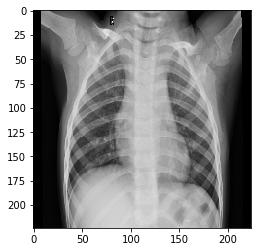

[1. 0.]
Reading 5221 images from train ...
Initial shapes. (5221, 224, 224, 3)   (5221, 2)
Final shapes. (5221, 224, 224, 3)   (5221, 2)


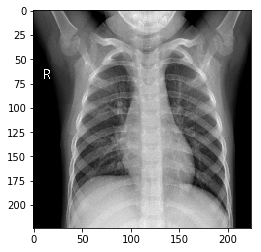

[1. 0.]
Reading 16 images from val ...
Initial shapes. (16, 224, 224, 3)   (16, 2)
Final shapes. (16, 224, 224, 3)   (16, 2)


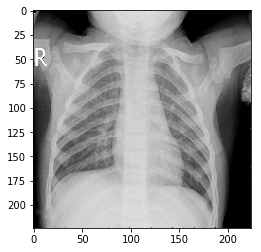

[1. 0.]


In [0]:
data, labels = dict(), dict()

for directory in DIRECTORIES:
    # get data and labels
    data[directory], labels[directory] = get_data(directory)

    # plot an image with label
    plt.imshow(data[directory][0])
    plt.show()
    print(labels[directory][0])

## CNN definition

In [0]:
# define the model we want to use
MODEL_NAME = 'vgg19'

# get the accurate model with weights
model = get_cnn_model(MODEL_NAME)
#model.summary()

# compile the model with optimizers and metrics
model = compile_model(model, MODEL_NAME)

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## CNN training
### USE IT WITH CAUTION, IT CAN TAKE TIME

In [0]:
# !!! WARNINGS !!!
# train or not is a question of time
model, history = train_model(model,
                             MODEL_NAME,
                             train_data=data['train'],
                             train_labels=labels['train'],
                             val_data=data['val'],
                             val_labels=labels['val'],
                             epoch=50,
                             batch_size=16,
                             metric='val_loss',
                             save_best_only=True,
                             stop_after=5)

Training vgg19 model during 50 epochs
327.0 train and 16 val steps per epoch.
Train on 5221 samples, validate on 16 samples
Epoch 1/50
5221/5221 [==============================] - 103s 20ms/step - loss: 0.1612 - acc: 0.8812 - val_loss: 0.1571 - val_acc: 0.9375

Epoch 00001: val_loss improved from inf to 0.15707, saving model to drive/My Drive/master1/medical_image_recognition/models/chest_xray/epoch01_valacc0.937500.hdf5
Epoch 2/50
5221/5221 [==============================] - 100s 19ms/step - loss: 0.0566 - acc: 0.9630 - val_loss: 0.1043 - val_acc: 0.9375

Epoch 00002: val_loss improved from 0.15707 to 0.10434, saving model to drive/My Drive/master1/medical_image_recognition/models/chest_xray/epoch02_valacc0.937500.hdf5
Epoch 3/50
5221/5221 [==============================] - 100s 19ms/step - loss: 0.0472 - acc: 0.9705 - val_loss: 0.0302 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.10434 to 0.03016, saving model to drive/My Drive/master1/medical_image_recognition/models/ches

## CNN results

In [1]:
# choose the weights to load into model
BEST_WEIGHTS = MODEL_PATH + 'epoch02_valacc0.937500.hdf5'
model.load_weights(BEST_WEIGHTS)

# let's test our model !
test_model(model, MODEL_NAME, data['test'], labels['test'], batch_size=16)

NameError: ignored